In [2]:
from room import *
from ray_tracing import RayTracingSolver
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

100%|██████████| 5000/5000 [00:06<00:00, 775.86it/s] 


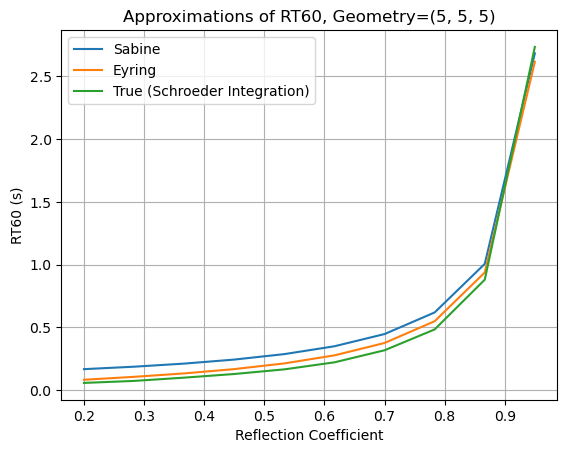

MSE Sabine:  0.013521015259857938
MSE Eyring:  0.0034662791759288124


100%|██████████| 5000/5000 [00:05<00:00, 908.47it/s] 


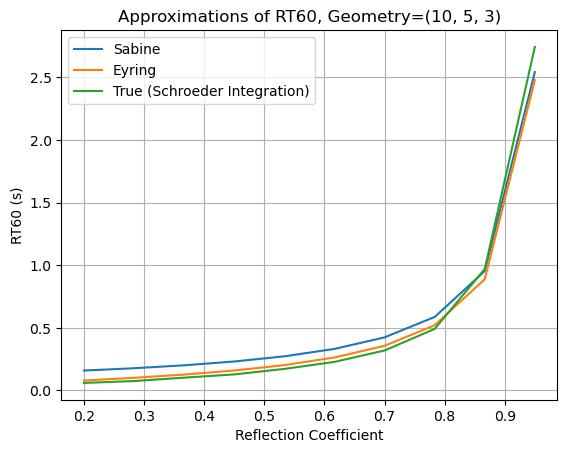

MSE Sabine:  0.012217036363615718
MSE Eyring:  0.008391251240832532


100%|██████████| 5000/5000 [00:04<00:00, 1072.29it/s]


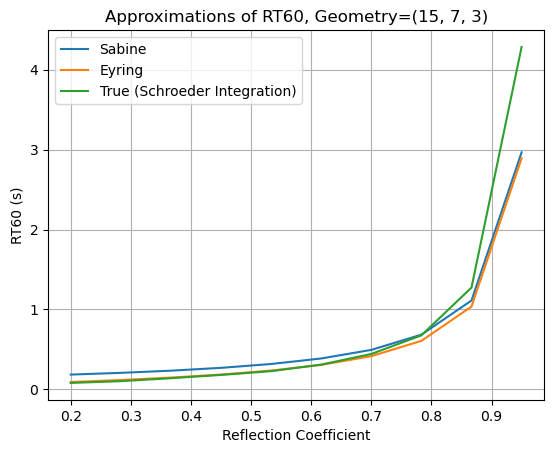

MSE Sabine:  0.1818937447948921
MSE Eyring:  0.20029007408227315


In [11]:
from room import *
from ray_tracing import RayTracingSolver
import numpy as np

def gaussian(mu=0, sigma=0.1):
    return lambda x: np.exp(-0.5 * ((x - mu) / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi))

# Fixed room geometry
x_dim, y_dim, z_dim = 5, 5, 5

for room_geometry in [(5, 5, 5), (10, 5, 3), (15, 7, 3)]:
    x_dim, y_dim, z_dim = room_geometry
    x_bounds = (-x_dim/2, x_dim/2)
    y_bounds = (-y_dim/2, y_dim/2)
    z_bounds = (-z_dim/2, z_dim/2)
    volume = x_dim * y_dim * z_dim
    surface_area = 2 * (x_dim*y_dim + y_dim*z_dim + x_dim*z_dim)

    reflection_coeffs = np.linspace(0.2, 0.95, 10)
    sabine_list = []
    eyring_list = []
    gaussian_schroeder_list = []

    for reflection_eff in reflection_coeffs:
        sabine_rt60 = 0.161 * volume / (surface_area * (1 - reflection_eff))
        eyring_rt60 = -0.161 * volume / (surface_area * np.log(reflection_eff))
        room = Room(bounds={'x': x_bounds, 'y': y_bounds, 'z': z_bounds}, reflection_eff=reflection_eff, dimension=3)
        power = 10
        num_rays = 5000
        sources = [Source(position=[0, 0, 0], power=power, num_rays=num_rays, dimension=3)]
        receivers = [Receiver(position=[0, 0, 0], radii=[0.1, 0.1, 0.1], type="virtual")]
        solver = RayTracingSolver(room, sources, receivers, max_time=sabine_rt60 * 5, energy_threshold=power / num_rays * 1e-7)
        solution = solver.solve()
        sigma = 0.01 * sabine_rt60
        rt60_gaussian_schroeder = solution.get_RT60(kernel_func=gaussian(mu=5*sigma, sigma=sigma), method="schroeder", aggregate=True)[0]
        sabine_list.append(sabine_rt60)
        eyring_list.append(eyring_rt60)
        gaussian_schroeder_list.append(rt60_gaussian_schroeder)

    plt.plot(reflection_coeffs, sabine_list, label='Sabine')
    plt.plot(reflection_coeffs, eyring_list, label='Eyring')
    plt.plot(reflection_coeffs, gaussian_schroeder_list, label='True (Schroeder Integration)')
    plt.xlabel('Reflection Coefficient')
    plt.ylabel('RT60 (s)')
    plt.title('Approximations of RT60, Geometry={}'.format((x_dim, y_dim, z_dim)))
    plt.legend()
    plt.grid()
    plt.show()

    # compute MSEs
    mse_sabine = np.mean((np.array(sabine_list) - np.array(gaussian_schroeder_list)) ** 2)
    mse_eyring = np.mean((np.array(eyring_list) - np.array(gaussian_schroeder_list)) ** 2)
    print("MSE Sabine: ", mse_sabine)
    print("MSE Eyring: ", mse_eyring)

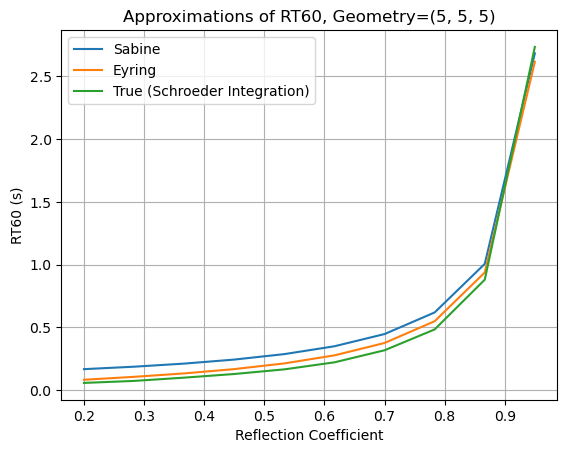

MSE Sabine:  0.013521015259857938
MSE Eyring:  0.0034662791759288124


In [12]:
df = pd.read_csv('sabine_analysis.csv')

In [25]:
df

,x_dim,y_dim,z_dim,reflection_eff,receiver_x,receiver_y,receiver_z,volume,surface_area,sabine_rt60,eyring_rt60,rt60_threshold,rt60_schroeder,rt60_gaussian_schroeder
0,6.446914,19.627368,5.650931,0.281772,"[1.7454088400556516, 8.691795396336275, -0.193...","[0.10561846412483218, -4.494750934869482, 1.30...","[2.358358092925919, -0.9043996340225184, -1.42...",715.045839,547.759800,0.292622,0.165925,0.147037,0.104436,0.087
1,16.588571,7.681437,6.310122,0.892870,"[-2.537743540984484, 2.7628035244490823, -1.75...","[6.142843896445633, 1.2452024689274572, -2.423...","[4.674623625937665, -2.7282722394357846, -1.73...",804.061381,561.141549,2.153429,2.035902,4.270200,3.663062,3.640
2,6.483313,12.219335,16.200765,0.275405,"[2.2121864389445345, 1.4228397048099946, -6.88...","[-2.2070904577468635, 3.657872614781032, -4.02...","[1.456978328098275, 0.7872228481528112, 6.8305...",1283.453406,764.437976,0.373051,0.209623,0.270559,0.316363,0.285
3,6.591448,3.084330,19.853340,0.444305,"[-1.962247396966213, 0.2983943706173434, -7.20...","[-0.07971904921383134, 0.9593110269943165, 4.1...","[0.18472557959206648, -0.08804916470693067, 4....",403.622393,424.853416,0.275249,0.188543,0.192322,0.177574,0.171
4,3.491365,4.017594,15.484778,0.737926,"[0.04601781425693609, -0.4838303296111465, 6.7...","[-1.6074018267775334, -1.7678690771634684, 7.3...","[-0.6931792019853807, 0.5497681077778189, -6.4...",217.203183,260.602865,0.512022,0.441534,0.487632,0.560814,0.537
5,14.611157,16.855224,7.959110,0.447723,"[-0.6746707925152147, 8.317092969735087, 1.021...","[-0.8090891446915276, -3.803621527967824, 3.45...","[-5.835344718254497, 0.024719387670502874, -1....",1960.124355,993.437407,0.575191,0.395312,0.565097,0.525835,0.511
6,11.180600,10.678048,13.230301,0.942680,"[-3.772890538611165, 3.0266735560821347, -4.48...","[1.1775164257002422, 0.9847682852025647, 5.812...","[-0.7672192815927394, 5.088196689193717, -3.41...",1579.525840,817.166991,5.429189,5.272058,6.966355,4.775135,4.788
7,10.548151,8.067691,10.834622,0.730775,"[1.5988586652313013, -2.533183952989763, -1.61...","[4.0111821611807, -0.8370868735740764, 5.18555...","[0.9187080034488525, 2.1339141538992545, 4.362...",922.017907,573.589667,0.961277,0.825123,0.897694,1.008600,0.974
8,7.666752,16.781170,5.694753,0.656023,"[-3.5100235292541915, 2.830372972179641, -1.91...","[-3.299591525948887, 5.733641954861288, -0.587...","[0.28155974905694253, 6.8929525653229, -1.9821...",732.670219,535.763888,0.640076,0.522278,0.829902,0.813910,0.777
9,9.656366,4.785507,17.256535,0.269465,"[-3.0475594436674127, 1.8119364504559081, 5.40...","[-4.422485419350366, -1.9453376007240457, 6.52...","[1.944320724255069, -1.3575155718455083, 0.727...",797.434942,590.854592,0.297440,0.165704,0.210538,0.197306,0.180


MSE Sabine:  0.19714472732520222
MSE Eyring:  0.21460453710147606


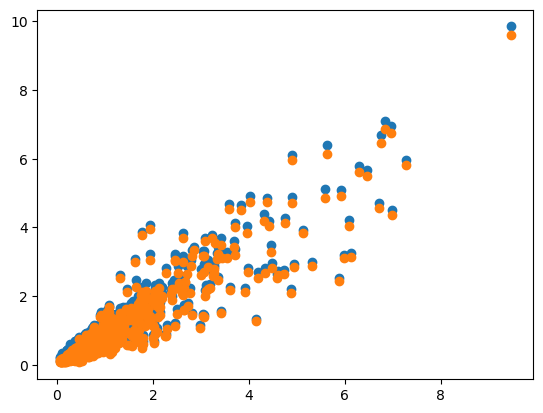

In [15]:
plt.scatter(df['rt60_gaussian_schroeder'], df['sabine_rt60'])
plt.scatter(df['rt60_gaussian_schroeder'], df['eyring_rt60'])
# compute MSE
mse_sabine = np.mean((df['sabine_rt60'] - df['rt60_gaussian_schroeder']) ** 2)
mse_eyring = np.mean((df['eyring_rt60'] - df['rt60_gaussian_schroeder']) ** 2)
print("MSE Sabine: ", mse_sabine)
print("MSE Eyring: ", mse_eyring)

/var/folders/7s/xg01j8rs6lj189rx59yby1xr0000gn/T/ipykernel_91615/1376428503.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


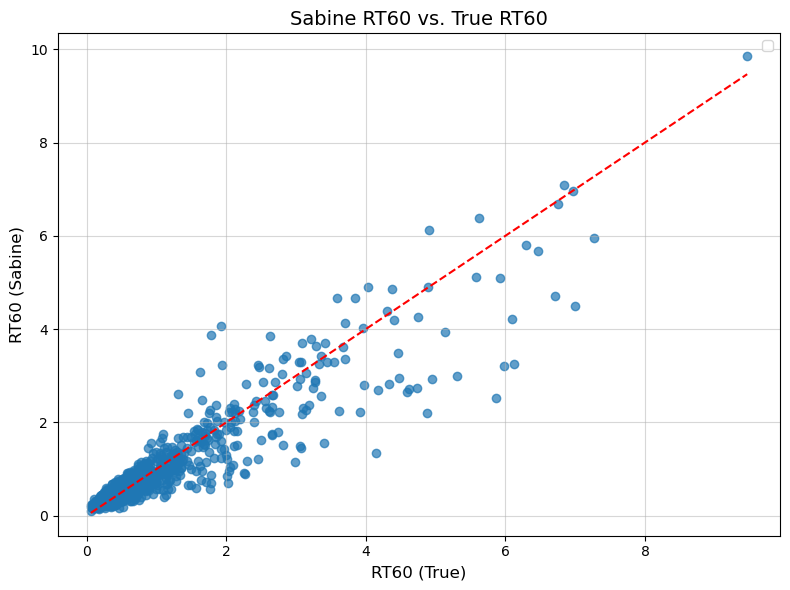

MSE Sabine:  0.19714472732520222


In [27]:
plt.figure(figsize=(8, 6))
plt.scatter(df['rt60_gaussian_schroeder'], df['sabine_rt60'], alpha=0.7)
plt.plot([df['rt60_gaussian_schroeder'].min(), df['rt60_gaussian_schroeder'].max()],
         [df['rt60_gaussian_schroeder'].min(), df['rt60_gaussian_schroeder'].max()],
         color='red', linestyle='--')
plt.xlabel('RT60 (True)', fontsize=12)
plt.ylabel('RT60 (Sabine)', fontsize=12)
plt.title('Sabine RT60 vs. True RT60', fontsize=14)
plt.grid(True, alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()
# compute MSE
mse_sabine = np.mean((df['sabine_rt60'] - df['rt60_gaussian_schroeder']) ** 2)
print("MSE Sabine: ", mse_sabine)

/var/folders/7s/xg01j8rs6lj189rx59yby1xr0000gn/T/ipykernel_91615/209508326.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


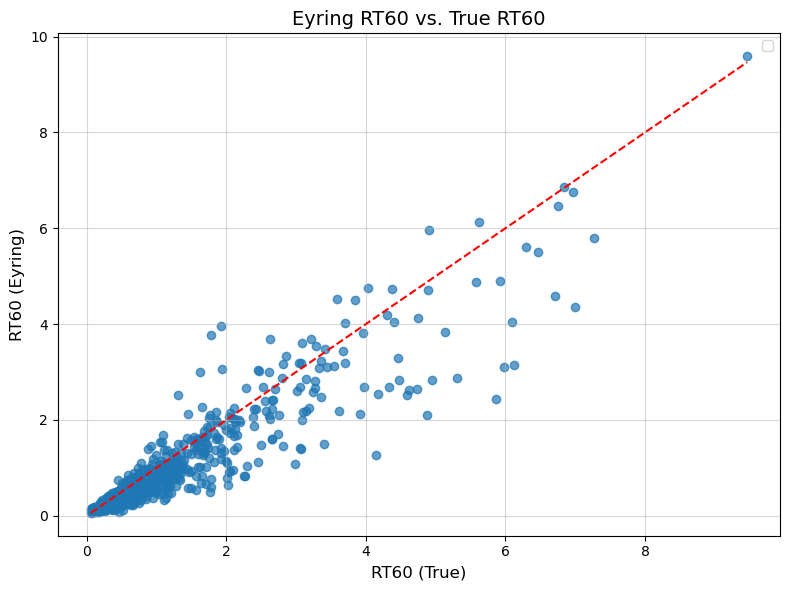

MSE Eyring:  0.21460453710147606


In [28]:
plt.figure(figsize=(8, 6))
plt.scatter(df['rt60_gaussian_schroeder'], df['eyring_rt60'], alpha=0.7)
plt.plot([df['rt60_gaussian_schroeder'].min(), df['rt60_gaussian_schroeder'].max()],
         [df['rt60_gaussian_schroeder'].min(), df['rt60_gaussian_schroeder'].max()],
         color='red', linestyle='--')
plt.xlabel('RT60 (True)', fontsize=12)
plt.ylabel('RT60 (Eyring)', fontsize=12)
plt.title('Eyring RT60 vs. True RT60', fontsize=14)
plt.grid(True, alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()
# compute MSE
mse_eyring = np.mean((df['eyring_rt60'] - df['rt60_gaussian_schroeder']) ** 2)
print("MSE Eyring: ", mse_eyring)

In [35]:
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Add new feature
df['vol_over_sa_refl'] = df['volume'] / (df['surface_area'] * (1 - df['reflection_eff']))

# Features and target
features = ['x_dim', 'y_dim', 'z_dim', 'volume', 'surface_area', 'reflection_eff', 'vol_over_sa_refl']
target = 'rt60_gaussian_schroeder'

X = df[features]
y = df[target]

# Split data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Neural network regressor
mlp = MLPRegressor(hidden_layer_sizes=(32, 16), activation='relu', max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)

# Predict and evaluate train
y_train_pred = mlp.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)
print("Train MSE:", mse_train)
print("Train R^2:", r2_train)

# Predict and evaluate test
y_pred = mlp.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("R^2:", r2)

Train MSE: 0.38314058289825526
Train R^2: 0.6885425503482371
MSE: 0.5173884646531446
R^2: 0.7177371958914553
